<a href="https://colab.research.google.com/github/deepjyotisaha85/eva4/blob/master/Session10/S10_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import sys
workingdir = '/content/gdrive/My Drive/Colab Notebooks/EVA4/Session 10'
sys.path.append(workingdir)

In [4]:
%matplotlib inline
import torch
import torchvision
import numpy as np
from utils import datapreparation
from utils import display
from model import dnn
from model import resnet
from utils import training
from utils import evaluate
from utils import lrfinder
from utils import gradcam 
from utils import gradvisualize 

  pip install torch-lr-finder -v --global-option="amp"


In [5]:
classes, trainloader, testloader = datapreparation.load(albumentations=True)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
CUDA Available? True


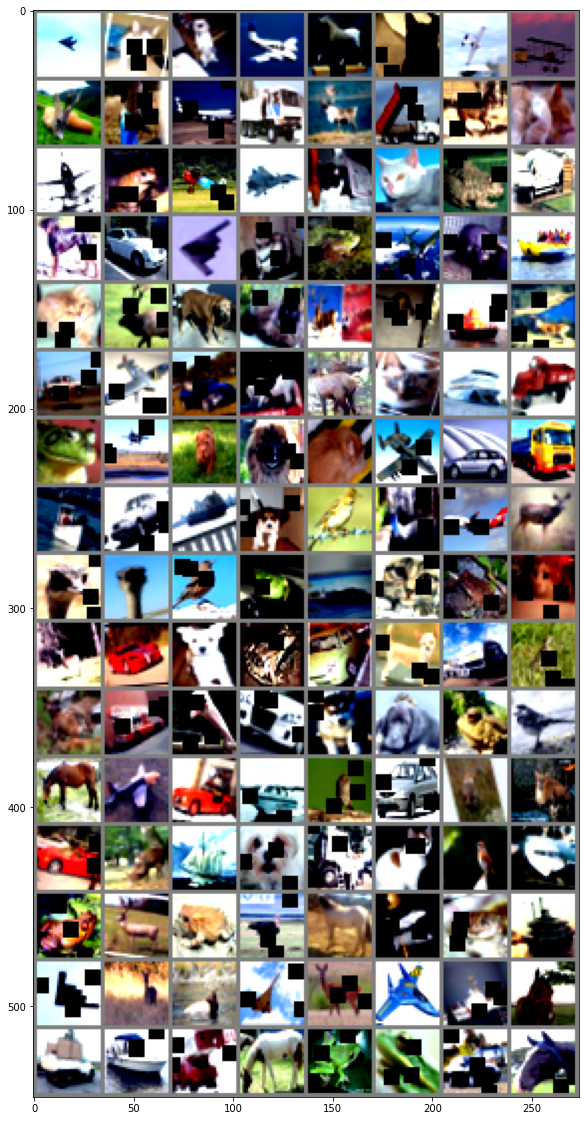

In [7]:
display.show_images(trainloader, classes, 20)

In [9]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
net = resnet.ResNet18()
model = net.to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


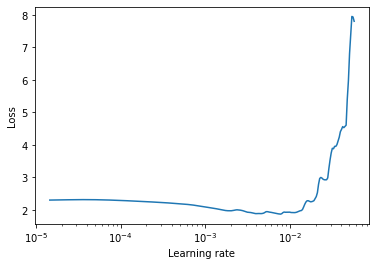

In [0]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
lr_finder =lrfinder.LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(trainloader, testloader, start_lr=1e-5, end_lr=2, num_iter=len(trainloader), step_mode="exp")
lr_finder.plot()
lr_finder.reset()

In [0]:
best_loss = lr_finder.best_loss
best_lr = lr_finder.history["lr"][lr_finder.history["loss"].index(best_loss)]
print("Best Loss: %s\nBest Learning Rate: %s" % (best_loss, best_lr))

Best Loss: 1.8735542645481678
Best Learning Rate: 0.007722774850140124


In [0]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = optim.SGD(model.parameters(), lr=best_lr, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=3,verbose=True, min_lr=1e-5)

In [15]:
EPOCHS = 20
misclassified_imgs = []
correct_imgs = []
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    training.train_model(model, device, trainloader, optimizer, criterion, epoch)
    misclassified_imgs, correct_imgs = training.test_model(model, device, criterion, testloader, epoch==EPOCHS-1)

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 1


Loss=1.1852833032608032 Batch_id=390 Accuracy=47.73: 100%|██████████| 391/391 [01:01<00:00,  6.37it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0087, Accuracy: 6051/10000 (60.51%)

EPOCH: 2


Loss=0.9632860422134399 Batch_id=390 Accuracy=64.25: 100%|██████████| 391/391 [01:06<00:00,  5.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0077, Accuracy: 6585/10000 (65.85%)

EPOCH: 3


Loss=0.6312929391860962 Batch_id=390 Accuracy=72.13: 100%|██████████| 391/391 [01:07<00:00,  5.76it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0057, Accuracy: 7573/10000 (75.73%)

EPOCH: 4


Loss=0.6367342472076416 Batch_id=390 Accuracy=76.56: 100%|██████████| 391/391 [01:08<00:00,  5.70it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0058, Accuracy: 7589/10000 (75.89%)

EPOCH: 5


Loss=0.43354877829551697 Batch_id=390 Accuracy=79.43: 100%|██████████| 391/391 [01:08<00:00,  5.73it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 7860/10000 (78.60%)

EPOCH: 6


Loss=0.5247392058372498 Batch_id=390 Accuracy=81.84: 100%|██████████| 391/391 [01:08<00:00,  5.73it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8230/10000 (82.30%)

EPOCH: 7


Loss=0.5210273265838623 Batch_id=390 Accuracy=83.52: 100%|██████████| 391/391 [01:08<00:00,  5.72it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8135/10000 (81.35%)

EPOCH: 8


Loss=0.4100993275642395 Batch_id=390 Accuracy=84.97: 100%|██████████| 391/391 [01:08<00:00,  5.71it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8308/10000 (83.08%)

EPOCH: 9


Loss=0.4121696352958679 Batch_id=390 Accuracy=85.99: 100%|██████████| 391/391 [01:08<00:00,  5.68it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8369/10000 (83.69%)

EPOCH: 10


Loss=0.2773192822933197 Batch_id=390 Accuracy=87.25: 100%|██████████| 391/391 [01:08<00:00,  5.71it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 8570/10000 (85.70%)

EPOCH: 11


Loss=0.2756878137588501 Batch_id=390 Accuracy=88.09: 100%|██████████| 391/391 [01:08<00:00,  5.72it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8462/10000 (84.62%)

EPOCH: 12


Loss=0.36451834440231323 Batch_id=390 Accuracy=88.75: 100%|██████████| 391/391 [01:08<00:00,  5.74it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 8623/10000 (86.23%)

EPOCH: 13


Loss=0.37979283928871155 Batch_id=390 Accuracy=89.43: 100%|██████████| 391/391 [01:08<00:00,  5.72it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8634/10000 (86.34%)

EPOCH: 14


Loss=0.4061892628669739 Batch_id=390 Accuracy=90.32: 100%|██████████| 391/391 [01:08<00:00,  5.70it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8697/10000 (86.97%)

EPOCH: 15


Loss=0.31359195709228516 Batch_id=390 Accuracy=90.73: 100%|██████████| 391/391 [01:08<00:00,  5.69it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8584/10000 (85.84%)

EPOCH: 16


Loss=0.32095080614089966 Batch_id=390 Accuracy=91.13: 100%|██████████| 391/391 [01:08<00:00,  5.71it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 8745/10000 (87.45%)

EPOCH: 17


Loss=0.31250515580177307 Batch_id=390 Accuracy=91.83: 100%|██████████| 391/391 [01:08<00:00,  5.69it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 8799/10000 (87.99%)

EPOCH: 18


Loss=0.15358616411685944 Batch_id=390 Accuracy=92.24: 100%|██████████| 391/391 [01:08<00:00,  5.69it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8664/10000 (86.64%)

EPOCH: 19


Loss=0.1957092434167862 Batch_id=390 Accuracy=92.76: 100%|██████████| 391/391 [01:08<00:00,  5.69it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8770/10000 (87.70%)

EPOCH: 20


Loss=0.25525403022766113 Batch_id=390 Accuracy=93.32: 100%|██████████| 391/391 [01:08<00:00,  5.73it/s]



Test set: Average loss: 0.0035, Accuracy: 8736/10000 (87.36%)



GroundTruth:  truck  ship  bird horse  frog
Predicted:  truck  ship  bird horse  frog


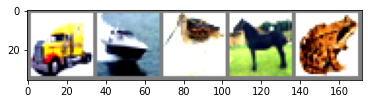

In [16]:
evaluate.show_predicted_actual(model, device, testloader, classes)

In [17]:
evaluate.evaluate_accuracy(model, device, testloader)

Accuracy of the network on the 10000 test images: 87 %


In [18]:
evaluate.evaluate_classwise_accuracy(model, device, classes, testloader)

Accuracy of plane : 84 %
Accuracy of   car : 97 %
Accuracy of  bird : 82 %
Accuracy of   cat : 72 %
Accuracy of  deer : 94 %
Accuracy of   dog : 70 %
Accuracy of  frog : 94 %
Accuracy of horse : 91 %
Accuracy of  ship : 95 %
Accuracy of truck : 89 %


Visualize GradCam

In [20]:
target_layers = ["layer1","layer2","layer3","layer4"]
viz_cam = gradvisualize.VisualizeCam(model, classes, target_layers)
print (viz_cam)

In [21]:
#len(testloader.dataset)
print(misclassified_imgs[0]["img"])

tensor([[[ 1.7096,  1.7413,  1.7731,  ...,  1.7890,  1.7890,  1.7731],
         [ 1.7096,  1.7413,  1.7572,  ...,  1.7572,  1.7572,  1.7572],
         [ 1.7096,  1.7413,  1.7413,  ...,  1.7255,  1.7255,  1.7413],
         ...,
         [ 1.3604,  1.2810,  1.3445,  ..., -0.1160, -0.2747, -0.5287],
         [ 0.6936,  0.6619,  0.7571,  ...,  0.4555,  0.3285,  0.2650],
         [ 0.2967, -0.0525,  0.0110,  ...,  0.1856,  0.1697,  0.1380]],

        [[ 1.7564,  1.7886,  1.8208,  ...,  1.8530,  1.8530,  1.8369],
         [ 1.7564,  1.7886,  1.8047,  ...,  1.8208,  1.8208,  1.8208],
         [ 1.7564,  1.7886,  1.7886,  ...,  1.7886,  1.7886,  1.8047],
         ...,
         [ 1.2249,  1.1282,  1.1765,  ..., -0.2730, -0.4019, -0.6273],
         [ 0.5645,  0.5001,  0.5645,  ...,  0.3068,  0.1941,  0.1619],
         [ 0.1941, -0.2086, -0.1764,  ...,  0.0652,  0.0491,  0.0330]],

        [[ 1.8610,  1.8909,  1.9209,  ...,  1.8610,  1.8610,  1.8460],
         [ 1.8610,  1.8909,  1.9059,  ...,  1

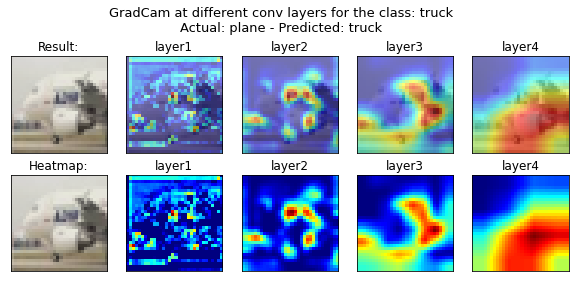

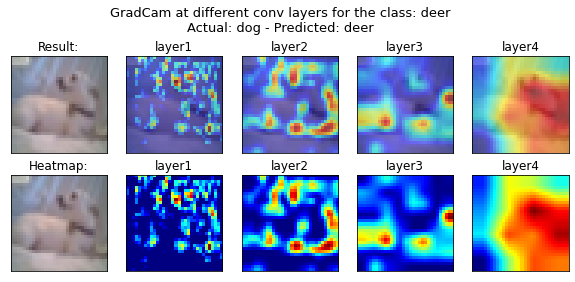

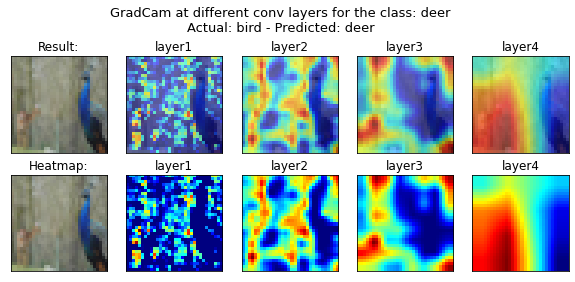

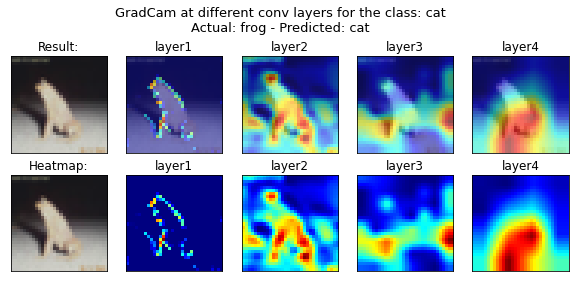

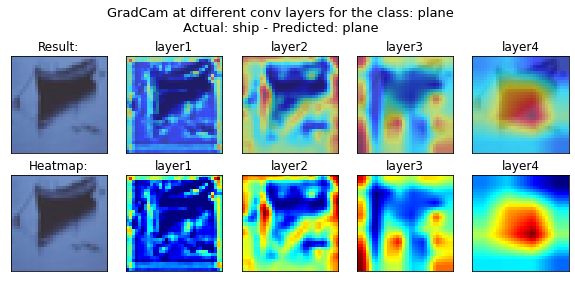

In [22]:
#GradCam for incorrectly classified images

num_img = 5
incorrect_pred_imgs = []
truth_inds = []
for i in range(num_img):
  incorrect_pred_imgs.append(torch.as_tensor(misclassified_imgs[i]["img"]))
  truth_inds.append(misclassified_imgs[i]["target"])
  #incorrect_pred_imgs
viz_cam(torch.stack(incorrect_pred_imgs), truth_inds, target_layers, metric="incorrect")

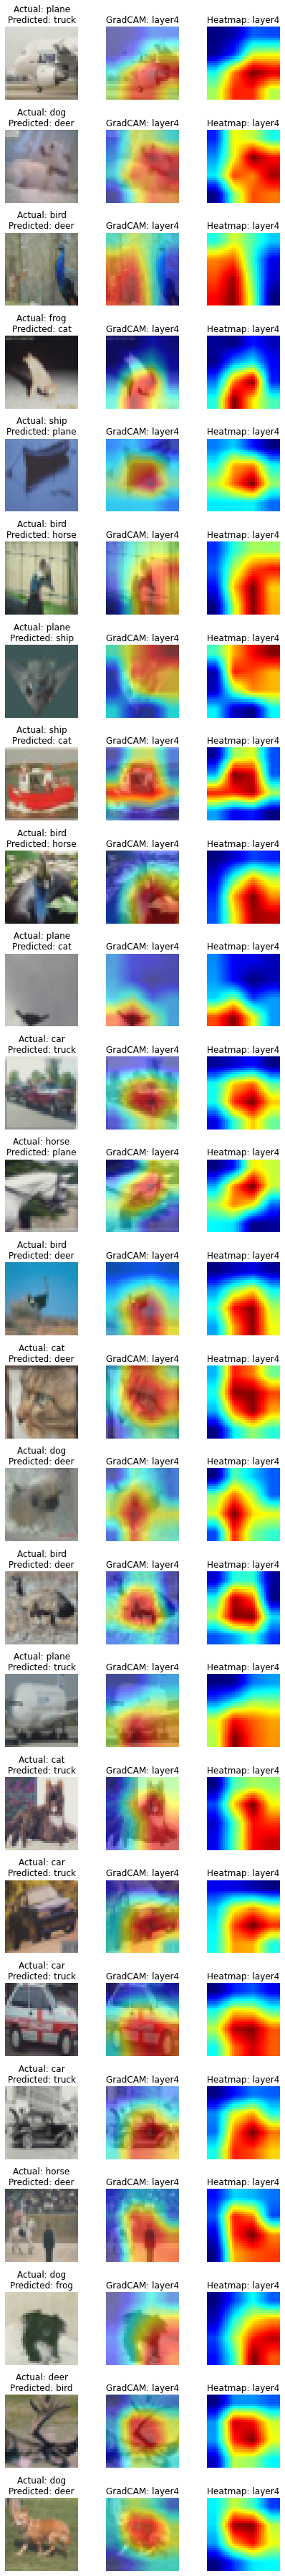

In [23]:
num_img = 25
incorrect_pred_imgs = []
truth_inds = []
for i in range(num_img):
  incorrect_pred_imgs.append(torch.as_tensor(misclassified_imgs[i]["img"]))
  truth_inds.append(misclassified_imgs[i]["target"])
viz_cam(torch.stack(incorrect_pred_imgs), truth_inds, target_layers, metric="incorrect", per_image=False)